<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/shruti-working/zindi_airstrip_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [1]:
%%capture
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert
!pip -q install segmentation-models-pytorch
!pip -q install albumentations

In [26]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import rasterio.mask
from shapely.geometry import box
from pyproj import Transformer
from rasterio.io import MemoryFile
from rasterio.transform import from_bounds

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utility libraries
import glob
import re
import shutil

## Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# clone the main branch from GitHub to get all the data and files from there onto the current runtime session
!apt-get install git
!git clone https://github.com/liangchow/zindi-amazon-secret-runway.git
!git pull # pulls the latest changes from repo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fatal: destination path 'zindi-amazon-secret-runway' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


## Set shared project folder on Google Drive
The satellite images for inference and model files stored in a shared folder `Zindi-Amazon` on Google Drive. To access the shared folder in Google Colab, first create a shortcut to the shared folder. Copy the shortcut to your Google Drive.

Now you can access `Zindi-Amazon` like any other folder in your Google Drive.

In [5]:
shared_path = '/content/drive/MyDrive/Zindi-Amazon/'

Create a `working` folder in Google Colab runtime for storing intermediate data products. This folder is deleted at the end of your session.

In [6]:
# Define the path for the new folder
working_path = '/content/working'

# Create the folder if it doesn't already exist
if not os.path.exists(working_path):
    os.makedirs(working_path)
    print(f"Folder created: {working_path}")
else:
    print(f"Folder already exists: {working_path}")

Folder already exists: /content/working


# Get list of AOIs and Models


In [7]:
aoi_list = []
model_list = []

In [8]:
base_aoi_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/shp_test_AOIs'

# Get a list of all shapefiles in the folder
shapefiles = glob.glob(f'{base_aoi_path}/*.shp')

# Extract `year_month` from each file path
for shp in shapefiles:
    match = re.search(r'(\d{4}_\d{2})', shp)  # Looks for pattern like 2021_04
    if match:
        aoi_list.append(match.group(1))

print(f"Total number of AOIs: {len(aoi_list)}")
print('\n'.join([f"{index}: {item}" for index, item in enumerate(aoi_list)]))

Total number of AOIs: 11
0: 2021_04
1: 2020_01
2: 2024_01
3: 2023_01
4: 2021_02
5: 2021_01
6: 2022_02
7: 2020_02
8: 2021_03
9: 2020_03
10: 2022_01


In [9]:
# Get a list of all models in the folder
models = glob.glob(f'{shared_path}models/*.pth')

models_list = []
for model_path in models:
  # Split the path and extract the part with `model_`
  model_name = model_path.split('/')[-1].replace('zindi_best_', '').replace('.pth', '')
  models_list.append(model_name)

print(f"Total number of models: {len(models_list)}")
print('\n'.join([f"{index}: {item}" for index, item in enumerate(models_list)]))

Total number of models: 9
0: model_20241022
1: model_20241028_200m_lr0005
2: model_20241028_100m_lr0005
3: model_20241028_50m_lr0005
4: model_20241028_20m_lr0005
5: model_20241028_10m_lr0005
6: model_20241030_20m_lr0005_B4_B3_B2_VV
7: model_20241030_20m_lr0005_B4_B3_B2_B8
8: model_20241030_20m_lr0005_B4_B3_B2_B8_VV


**Note: Update selected aoi & model in the cell below**

In [118]:
aoi_name = aoi_list[9]
model_name = models_list[6]

print(f"Selected AOI: {aoi_name}")
print(f"Selected Model: {model_name}")

Selected AOI: 2020_03
Selected Model: model_20241030_20m_lr0005_B4_B3_B2_VV


**Note: Update list of `additional_bands` in the cell below depending on the model**

In [11]:
#additional_bands = ['B8', 'B11', 'B12', 'VV', 'VH', 'VV_VH_Ratio']
#additional_bands = ['B8', 'VV']
additional_bands = ['VV']

# Load selected model file

**Note: Run the cell below if you update the model**

In [12]:
# UNet model with ResNet50 encoder
def get_model():
    model = smp.Unet(
        encoder_name='resnet50', # Choose encoder
        encoder_weights='imagenet', # Use pre-trained weights
        in_channels=int(len(additional_bands) + 3), # RGB + other channels
        classes=1, # Binary segmentation
    )
    return model


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_model().to(device)
model.load_state_dict(torch.load(f'{shared_path}models/zindi_best_{model_name}.pth', map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_name))

# Check the number of input channels in the model
input_channels = model.encoder.conv1.in_channels
print(f"The model expects {input_channels} input channels.")

/tmp/ipykernel_59586/1307594665.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{shared_path}models/zindi_best_{model_name}.pth', map

Model file model_20241030_20m_lr0005_B4_B3_B2_VV successfully loaded.
The model expects 4 input channels.


# Load AOI boundary

**Note: Run the cell below if you update the aoi**

In [119]:
# Read data using GeoPandas
shapefile = os.path.join(base_aoi_path, f'aoi_{aoi_name}.shp')
aoiboundary = gpd.read_file(shapefile )
aoicrs = aoiboundary.crs
print("AOI CRS: {}".format(aoicrs))
aoiboundary

AOI CRS: EPSG:32718


,MINX,MINY,MAXX,MAXY,CNTX,CNTY,AREA,PERIM,HEIGHT,WIDTH,geometry
0,455485.826987,9.055857e+06,470895.826987,9.071127e+06,463190.826987,9.063492e+06,235310700.0,61360.0,15270.0,15410.0,"POLYGON ((455485.827 9055857.351, 455485.827 9..."


# Download inference image for AOI and select the bands

**Note: Run the cell below if you update the aoi**

Fetch the satellite raster image using the Rasterio library. The images in the `inference` folder have 9 bands from Sentinel1 and Sentinel2 satellites. Create a subset of the bands for inference depending on the model. Save this image in the `working` folder

In [120]:
def get_inference_image(aoi, transform=None, additional_bands=[]):
  image_path = os.path.join(shared_path + 'inference/', 'Sentinel_AllBands_Inference_{}.tif'.format(aoi))

  with rasterio.open(image_path) as src:

      # Initialize dictionary for all required bands
      bands = {desc: src.read(i + 1) for i, desc in enumerate(src.descriptions) if desc in ['B4', 'B3', 'B2'] + additional_bands}

      # Ensure all specified bands are present
      required_bands = ['B4', 'B3', 'B2'] + additional_bands
      for band in required_bands:
          if band not in bands:
              raise ValueError(f"Missing band {band} in image: {image_path}")

      # Update metadata for the new file
      out_meta = src.meta.copy()
      out_meta.update({
          "count": len(required_bands)  # Number of bands to save in the new file
      })

      # Rescale RGB bands (B4, B3, B2) only
      rgb_image = np.stack([bands['B4'], bands['B3'], bands['B2']], axis=-1)
      rgb_image = np.clip(rgb_image, 0, 2000) / 2000  # Scaling between 0 and 1

      # Stack additional bands without normalization
      other_band_images = [bands[band] for band in additional_bands]
      if other_band_images:
          full_image = np.concatenate([rgb_image] + [np.expand_dims(b, axis=-1) for b in other_band_images], axis=-1)
      else:
          full_image = rgb_image

      band_data = np.moveaxis(full_image, -1, 0)  # Reorder to (bands, height, width)

      # Output file
      output_file = os.path.join(working_path, 'Sentinel_AllBands_Inference_{}_subset.tif'.format(aoi_name))

      # Write the subset of bands to a new TIFF file
      with rasterio.open(output_file, "w", **out_meta) as dest:
          dest.write(band_data)
          print(f"New TIFF file with selected bands created at: {output_file}")

  return output_file

# Download inference image
inference_image_path = get_inference_image(aoi_name, additional_bands=additional_bands)

# Check image channels
with rasterio.open(inference_image_path) as src:
    print(f"Number of bands in the image: {src.count}")

New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2020_03_subset.tif
Number of bands in the image: 4


# Create a grid of tiles

**Note: Run the cell below if you update the aoi**

During training, the model learned to recognize patterns within a specific patch size. The inference image is split up into same sized patches before running inference. To do this first create a geosjon file of the tiles for the aoi and save it in the `working` folder

In [121]:
# Define patch size
patch_size = 224

# Function to generate geojson tiles
def generate_tiles(image_file, output_file, area_str, size=224):
    """Generates square polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains square polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 224 x 224 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to AOI crs
    results.crs = {'init' : aoicrs}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

# Create geojson file
output_patch_file = os.path.join(working_path, 'aoi_{}_{}x{}px_patches.geojson'.format(aoi_name, patch_size, patch_size))
tiles = generate_tiles(inference_image_path, output_patch_file, aoi_name, size=patch_size)

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/2353107 [00:00<?, ?it/s]

Data dimensions: (49, 2)


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,id,geometry
0,2020_03-0,"POLYGON ((457725.827 9068887.351, 457725.827 9..."
1,2020_03-1,"POLYGON ((459965.827 9068887.351, 459965.827 9..."
2,2020_03-2,"POLYGON ((462205.827 9068887.351, 462205.827 9..."


# Visualize tiles

**Note: Run the cell below if you update the aoi for a sanity check**

Let's open the inference raster file using Rasterio and superimpose the tiles.

(9055447.3511864, 9071127.3511864)

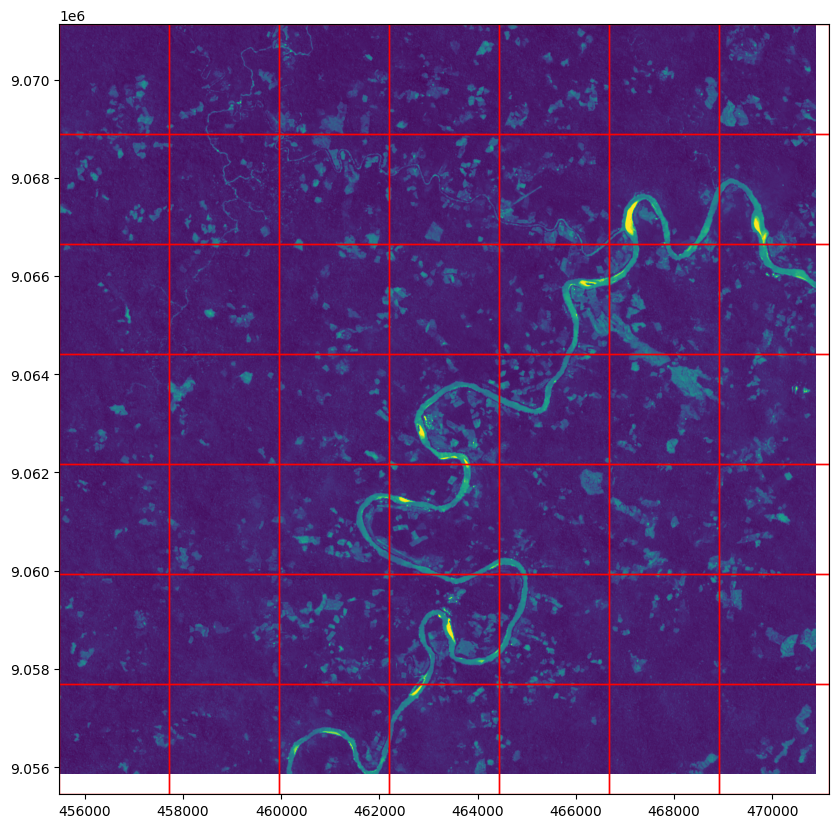

In [122]:
# Open image file using Rasterio
image = rio.open(inference_image_path)

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(10,10))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)

# Get the extent of the tiles
tiles_extent = tiles.total_bounds  # returns [minx, miny, maxx, maxy]

# Show the image and set plot limits based on tiles extent
show(image, ax=ax)
ax.set_xlim(tiles_extent[0], tiles_extent[2])  # Set x limits (minx, maxx)
ax.set_ylim(tiles_extent[1], tiles_extent[3])  # Set y limits (miny, maxy)

# Predict values

## Define data transformations

A set of data transformations to the test set were applied during training. Before running the inference images through the model, these same transformations are applied to the inference image.

In [76]:
# Augmentations using albumentations and PyTorch's ToTensor
def get_augmentations(option='inference', optional_bands=None):
    # Define mean and std for RGB (B4, B3, B2)
    base_band_means = {'B4': 0.485, 'B3': 0.456, 'B2': 0.406}
    base_band_stds = {'B4': 0.229, 'B3': 0.224, 'B2': 0.225}

    # Define mean and std for additional optional bands
    optional_band_means = {'B8': 2987.760, 'B11': 1656.303, 'B12': 729.068, 'VV': -8.048, 'VH': -14.456, 'VV_VH_Ratio': 0.547}
    optional_band_stds = {'B8': 504.165, 'B11': 314.123, 'B12': 203.183, 'VV': 1.911, 'VH': 1.825, 'VV_VH_Ratio': 0.064}

    # Combine base bands and optional bands
    all_band_means = {**base_band_means, **optional_band_means}
    all_band_stds = {**base_band_stds, **optional_band_stds}

    # If optional_bands is specified, get only those; otherwise, default to RGB
    selected_bands = ['B4', 'B3', 'B2'] + (optional_bands if optional_bands else [])
    mean = tuple(all_band_means[band] for band in selected_bands)
    std = tuple(all_band_stds[band] for band in selected_bands)

    # # Define augmentation pipeline based on phase
    augmentations = {
        'train': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ],
        'val': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'test': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'inference': [
            A.CenterCrop(width=224, height=224),
        ]
    }

    if option not in augmentations:
        raise ValueError("Invalid option. Choose from 'train', 'val', 'test', or 'inference'.")

    # Add normalization and tensor transformation
    augmentations[option].extend([
        A.Normalize(mean=mean, std=std, max_pixel_value=1.0),
        ToTensorV2(),
    ])

    # Return the Compose pipeline
    return A.Compose(augmentations[option])

## Create a subfolder for model to store output

**Note: Run the cell below if you update the model**

In [106]:
def create_model_folder(name):

  # Define the path for the new folder
  local_folder_path = working_path + '/' + name

  # Create the folder in colab runtine if it doesn't already exist
  if not os.path.exists(local_folder_path):
      os.makedirs(local_folder_path)
      print(f"Folder created: {local_folder_path}")
  else:
      print(f"Folder already exists: {local_folder_path}")

  # Define the path for the new folder
  shared_folder_path = shared_path + 'Studies/' + name

  # Create the folder in colab runtine if it doesn't already exist
  if not os.path.exists(shared_folder_path):
      os.makedirs(shared_folder_path)
      print(f"Folder created: {shared_folder_path}")
  else:
      print(f"Folder already exists: {shared_folder_path}")

create_model_folder(model_name)

Folder already exists: /content/working/model_20241030_20m_lr0005_B4_B3_B2_VV
Folder already exists: /content/drive/MyDrive/Zindi-Amazon/Studies/model_20241030_20m_lr0005_B4_B3_B2_VV


## Run prediction for each image patch

In [97]:
def pad_image_patch(image, target_size=224):
    """Pads the image to `target_size` x `target_size` with zeroes if needed.

    Args:
      image (np.ndarray): The input image array (C, H, W).
      target_size (int): The target size for both width and height.

    Returns:
      padded_image (np.ndarray): The padded image in (C, H, W) format.
      padding (tuple): Padding applied as (top, bottom, left, right).
    """
    channels, height, width = image.shape

    # Calculate padding for height and width
    pad_top = (target_size - height) // 2 if height < target_size else 0
    pad_bottom = target_size - height - pad_top if height < target_size else 0
    pad_left = (target_size - width) // 2 if width < target_size else 0
    pad_right = target_size - width - pad_left if width < target_size else 0

    # Apply padding only if necessary
    if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
        padded_image = np.pad(image,
                              ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant',
                              constant_values=0)
    else:
        padded_image = image  # No padding needed

    # Return the padded image and the padding details
    return padded_image, (pad_top, pad_bottom, pad_left, pad_right)

In [79]:
def predict_airstrip(image, shape, model, optional_bands=None):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)

        # Pad image patch size
        padded_image, padding = pad_image_patch(out_image, patch_size)

        # Throw error if image bands dont match
        if padded_image.shape[0] != model.encoder.conv1.in_channels:
          raise Exception("Number of bands don't match")

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": padded_image.shape[1],
              "width": padded_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = os.path.join(working_path, 'temp.tif')
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(padded_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model

        # Use rasterio to read the image instead of Pillow
        # to avoid UnidentifiedImageError(msg)
        with rio.open(temp_tif) as dataset:
            image_data = dataset.read()
            image_data = image_data.transpose(1, 2, 0)  # Reorder dimensions to (height, width, channels)

        # Get the augmentation pipeline for inference
        augmentation_pipeline = get_augmentations(option='inference', optional_bands=optional_bands)

        # Apply the transformation to the image data
        augmented = augmentation_pipeline(image=image_data)

        input = augmented['image']  # Extract the transformed image tensor

        # Get the model's output
        output = model(input.unsqueeze(0))

        # Apply sigmoid if necessary to get probabilities between 0 and 1
        output = torch.sigmoid(output) # Uncomment if model outputs logits instead of probabilities

        # Threshold to get binary predictions (0 or 1)
        predictions = (output > 0.5).int() # Adjust threshold if needed

        # Return the entire prediction tensor
        return (predictions, padding)

    return None

Let's iterate over every tile and generate model predictions for the corresponding image patch. Overwriting each temporary TIFF file to save storage space.

**Note: Run the cell below if you update the aoi or model**

In [123]:
# Commence model prediction
all_predictions = []  # Store predictions for all tiles
all_padding = []  # Store predictions for all tiles
for index in tqdm(range(len(tiles)), total=len(tiles)):
    predictions, padding = predict_airstrip(inference_image_path, [tiles.iloc[index]['geometry']], model, additional_bands)
    all_predictions.append(predictions)
    all_padding.append(padding)

# Add predictions and padding information to the tiles GeoDataFrame
tiles["predictions"] = all_predictions
tiles["padding"] = all_padding

# Save the GeoDataFrame with predictions and padding
filepath = os.path.join(f"{working_path}/{model_name}", "{}_preds_and_padding.geojson".format(aoi_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/49 [00:00<?, ?it/s]

,id,geometry,predictions,padding
0,2020_03-0,"POLYGON ((457725.827 9068887.351, 457725.827 9...","[[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 0, 0, 0)"
1,2020_03-1,"POLYGON ((459965.827 9068887.351, 459965.827 9...","[[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 0, 0, 0)"
2,2020_03-2,"POLYGON ((462205.827 9068887.351, 462205.827 9...","[[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 0, 0, 0)"


## Create a predictions raster

- Process Each Image Patch: For each tile, extract the prediction patch, apply any necessary trimming, and keep track of it for the mosaic.
- Trim Padding: If padding is applied to an image patch, trim the patch using the padding information.
- Mosaic the Patches: Merge all processed patches directly into a single TIFF file without saving individual patches.

In [81]:
def process_and_mosaic_predictions(tiles, inference_image_path, model_name, aoi_name, working_path):
    """
    Processes each tile's prediction from the tiles GeoDataFrame, trims padding if applied,
    and mosaics all tiles into a single output TIFF file with the same extent and size as the inference image.

    Args:
      tiles (GeoDataFrame): GeoDataFrame containing tile geometries, padding, and predictions.
      inference_image_path (str): Path to the original input image file.
      model_name (str): Name of the model.
      aoi_name (str): Name of the Area of Interest (AOI).
      working_path (str): Directory to save the output file.

    Returns:
      str: Path to the saved mosaic TIFF file.
    """
    # Open the inference image to get its profile and dimensions
    with rio.open(inference_image_path) as src:
        profile = src.profile.copy()
        mosaic_shape = (profile['height'], profile['width'])  # Full extent size
        mosaic = np.zeros(mosaic_shape, dtype=np.uint8)  # Initialize blank mosaic

    # Process predictions for each tile
    for tile_index in tqdm(range(len(tiles)), desc="Processing tiles"):
        # Retrieve the prediction from the GeoDataFrame
        predictions = tiles.iloc[tile_index]['predictions']
        # Convert predictions from torch tensor to numpy array for easier processing
        predictions_np = predictions.squeeze().cpu().numpy()

        # Retrieve padding from the GeoDataFrame
        padding = tiles.iloc[tile_index]['padding']  # Assume padding is in (top, bottom, left, right
        # Trim padding from prediction numpy array if applied
        padding = tiles.iloc[tile_index]['padding']  # Assume padding is in (top, bottom, left, right) format
        if padding:
            pad_top, pad_bottom, pad_left, pad_right = padding
            predictions_np = predictions_np[
                pad_top: predictions_np.shape[0] - pad_bottom,
                pad_left: predictions_np.shape[1] - pad_right
            ]

        # Calculate the tile's position in the mosaic array based on its geometry bounds
        tile_geometry = tiles.iloc[tile_index]['geometry']
        minx, miny, maxx, maxy = tile_geometry.bounds
        tile_transform = from_bounds(minx, miny, maxx, maxy, predictions_np.shape[1], predictions_np.shape[0])

        # Convert the tile transform to pixel coordinates in the full mosaic
        row_start, col_start = rio.transform.rowcol(profile['transform'], minx, maxy)
        row_end, col_end = rio.transform.rowcol(profile['transform'], maxx, miny)

        # Ensure coordinates are integers and within bounds
        row_start, col_start = int(max(0, row_start)), int(max(0, col_start))
        row_end, col_end = int(min(mosaic_shape[0], row_end)), int(min(mosaic_shape[1], col_end))

        # Check if prediction is same as mosaic slice
        if (row_end - row_start, col_end - col_start) != predictions_np.shape:
          print(f"Prediction size: {predictions_np.shape}")
          print(f"Mosaic slice size: {(row_end - row_start, col_end - col_start)}")
          #raise Exception("Prediction size does not match mosaic slice size")
            #predictions_np = cv2.resize(predictions_np, (col_end - col_start, row_end - row_start))

        # Place the tile's prediction in the correct location within the mosaic array
        mosaic[row_start:row_end, col_start:col_end] = predictions_np

    # Update metadata for the mosaic to match the inference image
    profile.update({
        "driver": "GTiff",
        "count": 1  # Single band for predictions
    })

    # Save the mosaic as a GeoTIFF file on the shared drive
    output_predictions_mosaic = os.path.join(working_path, model_name, f"aoi_{aoi_name}_prediction_mosaic.tif")
    os.makedirs(os.path.dirname(output_predictions_mosaic), exist_ok=True)
    with rio.open(output_predictions_mosaic, "w", **profile) as dest:
        dest.write(mosaic, 1)

    # Visualize the mosaic
    show(mosaic, transform=profile['transform'])
    print(f"Prediction mosaic saved to: {output_predictions_mosaic}")

    return output_predictions_mosaic



**Note: Run the cell below if you update the aoi**

Processing tiles:   0%|          | 0/49 [00:00<?, ?it/s]

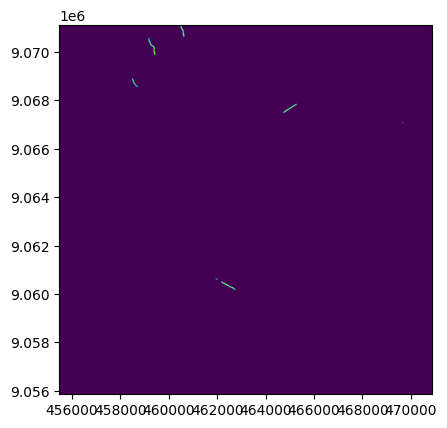

Prediction mosaic saved to: /content/working/model_20241030_20m_lr0005_B4_B3_B2_VV/aoi_2020_03_prediction_mosaic.tif
Prediction mosaic saved to: /content/drive/MyDrive/Zindi-Amazon/Studies/model_20241030_20m_lr0005_B4_B3_B2_VV


In [124]:
predictions_mosaic = process_and_mosaic_predictions(tiles, inference_image_path, model_name, aoi_name, working_path)

shared_folder_path = os.path.join(shared_path, 'Studies', model_name)

# Copy the mosaic file to the shared Google Drive folder
shutil.copy(predictions_mosaic, shared_folder_path)
print(f"Prediction mosaic saved to: {shared_folder_path}")

# Visualize Predictions on the satellite image

**Note: Run the cell below if you update the aoi**

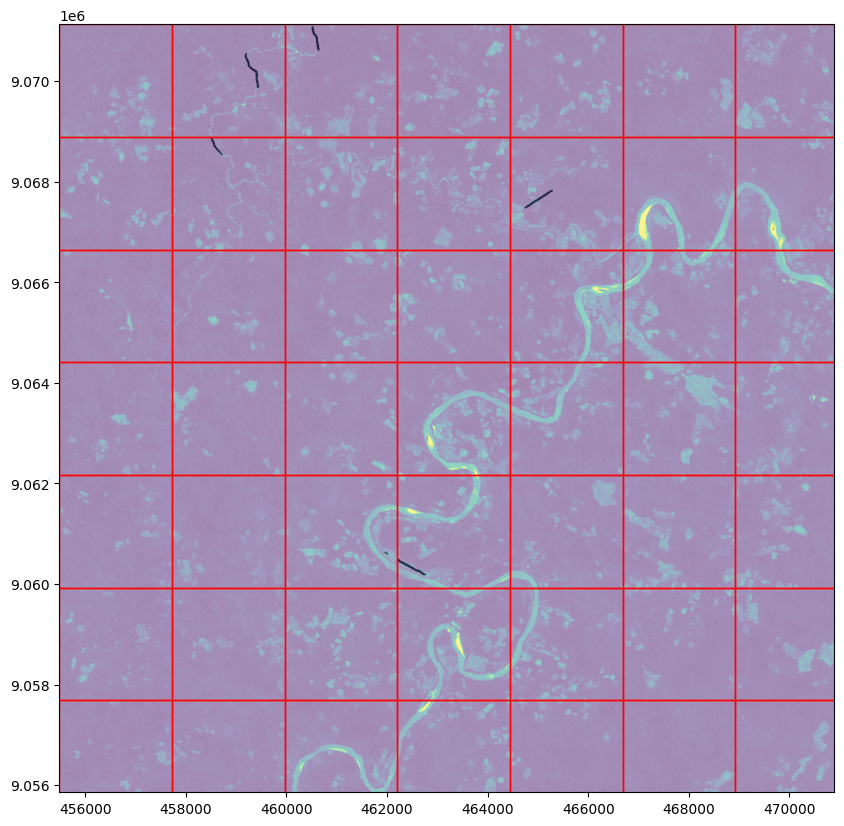

In [125]:
image = rio.open(inference_image_path)
predictions = rio.open(predictions_mosaic)

fig, ax = plt.subplots(figsize=(10, 10))

# Display the base image using imshow
show(image, ax=ax)
tiles.plot(facecolor="none", edgecolor='red', ax=ax)

# Get the extent of the image
image_extent = ax.get_images()[0].get_extent()

# Display the masked prediction data with transparency on top
show(
    predictions,
    ax=ax,
    cmap="binary",
    alpha=0.5,
    extent=image_extent  # Use the image extent for proper alignment
)

plt.show()

In [225]:
# Clean up working directory
!rm -rf /content/working/*